<a href="https://www.kaggle.com/code/rohitprasad612/covid19-deep-learning-using-x-ray?scriptVersionId=126935260" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

***Import Libraries And DataSet***

In [1]:
import os
import re 
import math
import pandas as pd
import numpy as np
import random as python_random
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications import ConvNeXtXLarge
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score


import cv2
from PIL import ImageFilter

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0117.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0101.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0108.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0110.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0119.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0115.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0116.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0105.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0106.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0121.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0111.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0103.jpeg
/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0120.jpeg
/kaggle/input/covid19-dataset-x-ray/Co

***Graph Function***

In [2]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(epochs, acc, label='training acc')
    ax1.plot(epochs, val_acc, label='validation acc')
    ax1.set_title('Accuracy')
    ax1.legend()

    ax2.plot(epochs, loss, label='training loss')
    ax2.plot(epochs, val_loss, label='validation loss')
    ax2.set_title('Loss')
    ax2.legend()

    plt.show()


**Generate IMage with randomness**

In [3]:
height, width = 224, 224
batch_size = 64
class_names = ['Normal', 'Viral Pneumonia', 'Covid']

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=20,
                                 horizontal_flip=True,
                                 zoom_range=0.2)
    
    generator = datagen.flow_from_directory(DIR,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=42,
                                            class_mode='sparse',
                                            target_size=(height, width),
                                            # classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
                                            classes=class_names)
    return generator

In [4]:
TRAINING_DIR = r'/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/train'
TESTING_DIR = r'/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
      'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


***Model History Generating Function***

In [5]:
os.makedirs('Model_history')
def history_to_csv(history_, filename):
    hist_df = pd.DataFrame(history_.history)
    # specify the full file path
    hist_csv_file = os.path.join('Model_history', filename)
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

***KFold***

In [6]:
# # define the number of splits
# k = 5

# # create the k-fold object
# kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# # define the models
# models = [('Vgg16', tf.keras.applications.vgg16.VGG16, 3),
#           ('InceptionV3', tf.keras.applications.InceptionV3, 3),
#           ('DenseNet201', tf.keras.applications.DenseNet201, 3),
#           ('ConvNeXtXLarge', tf.keras.applications.ConvNeXtLarge, 3),
#           ('EfficientNetV2S', tf.keras.applications.EfficientNetV2S, 3)]

# # iterate over the models
# for model_name, base_model_fn, n_classes in models:
#     # create the k-fold model object
#     model = create_custom_model(base_model_fn(weights='imagenet', include_top=False, input_shape=(height, width, 3)), 
#                                 (height, width, 3), False, n_classes)
    
#     # initialize the lists to store the performance measures
#     val_accs = []
#     val_losses = []
#     accuracies = []
    
#     # iterate over the k-folds
#     for i, (train_index, val_index) in enumerate(kfold.split(total_image)):
#         print(f'Fold {i+1}')
        
#         # create the data generators for the current fold
#         train_generator = generate_data(TRAINING_DIR)
#         test_generator = generate_data(TESTING_DIR)
        
#         # train and evaluate the model for the current fold
#         history = train_and_evaluate_model(model, f'{model_name}_fold{i+1}', epochs=50, monitor_acc='val_acc', monitor_val_loss='val_loss', patience=5, verbose=1)
        
#         # store the validation accuracy and validation loss for the current fold
#         val_accs.append(history.history['val_acc'][-1])
#         val_losses.append(history.history['val_loss'][-1])
        
#         # evaluate the model on the test set for the current fold
#         ytest, ypred, ypred_prob = evaluate_ensemble_model(model, test_generator)
#         accuracies.append(accuracy_score(ytest, ypred))
        
#     # print the performance measures for the current model
#     print(f'Validation Accuracy: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}')
#     print(f'Validation Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}')
#     print(f'Test Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}\n')


***Create Model, train, and evaluate it. And calculate performance of that model***

In [7]:
def create_custom_model(base_model, input_shape, trainable=False, n_classes=3):
    tf.keras.backend.clear_session()
    base_model.trainable = trainable

    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    model.compile(loss='SparseCategoricalCrossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['acc'])
    model.summary()
    return model
    
    
def train_and_evaluate_model(model, model_name, epochs=50, monitor_acc='acc', monitor_val_loss='val_loss', patience=5, verbose=1):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Model_new/{model_name}_best.h5', monitor=monitor_acc, verbose=verbose, mode='max', save_best_only=True)
    early = tf.keras.callbacks.EarlyStopping(monitor=monitor_val_loss, mode='min', restore_best_weights=True, patience=patience, verbose=verbose, min_delta=0.01)

    callbacks_list = [checkpoint, early]

    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=epochs,
        shuffle=False,
        verbose=verbose,
        callbacks=callbacks_list,
    )
    
    return history


def evaluate_ensemble_model(ensemble_model, test_generator, batch_size=64):
    ytest = np.array([])
    xtest = []

    for i in range(math.ceil(len(test_generator.classes) / batch_size)):
        xtest.append(test_generator[i][0])
        ytest = np.concatenate((ytest, test_generator[i][-1]))

    xtest = np.concatenate((xtest), axis=0)

    ypred_prob = ensemble_model.predict(xtest)
    ypred = np.argmax(ypred_prob, axis=1)

    plt.figure(figsize=(6, 6))
    hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                    yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])
    hm.set(xlabel='Predicted_labels')
    hm.set(ylabel='True_labels')
    print(classification_report(ytest, ypred))
    return ytest, ypred, ypred_prob


def calculate_performance_metrics(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    # Return results as a dictionary
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1-Score: {f1*100:.2f}%")


def predict_image(img_path, model_name):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    print('\n')
    actual_class = re.findall(r'\/(Normal|Viral\sPneumonia|Covid)\/',img_path)[0]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()
    
    pred = model_name.predict(img_tensor)

    # pred = model_vgg16.predict(img_tensor)
    print(pred)
    print(pred.argmax(axis=1))
    print(pred.max(axis=1))
    print('Predicted:', class_names[pred.argmax(axis=1)[0]])
    print('Actual:',actual_class)


***Vgg16***

In [8]:
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg16 = create_custom_model(base_model, input_shape, False, 3)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [9]:
history_vgg16 = train_and_evaluate_model(model_vgg16, 'Vgg16', epochs=50, monitor_acc='acc', monitor_val_loss='val_loss', patience=5, verbose=1)
history_to_csv(history_vgg16,'history_vgg16_new.csv')

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.2496 - acc: 0.3745
Epoch 1: acc improved from -inf to 0.37450, saving model to Model_new/Vgg16_best.h5
4/4 [==============================] - 33s 6s/step - loss: 1.2496 - acc: 0.3745 - val_loss: 1.1137 - val_acc: 0.3939
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.1644 - acc: 0.4422
Epoch 2: acc improved from 0.37450 to 0.44223, saving model to Model_new/Vgg16_best.h5
4/4 [==============================] - 15s 4s/step - loss: 1.1644 - acc: 0.4422 - val_loss: 1.0297 - val_acc: 0.3939
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 1.0455 - acc: 0.4622
Epoch 3: acc improved from 0.44223 to 0.46215, saving model to Model_new/Vgg16_best.h5
4/4 [==============================] - 15s 4s/step - loss: 1.0455 - acc: 0.4622 - val_loss: 0.9888 - val_acc: 0.5606
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.9773 - acc: 0.5378
Epoch 4: acc improved from 0.46215 to 0.537

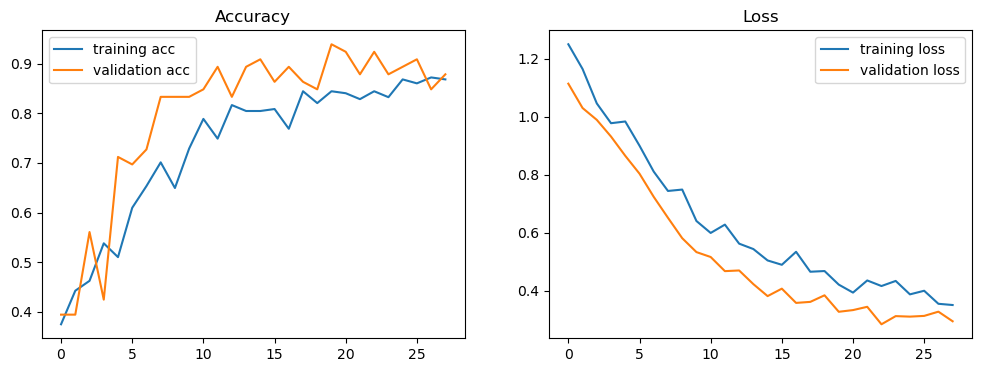

In [10]:
plot_learning_curve(history_vgg16)

3/3 [==============================] - 3s 35ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82        20
         1.0       0.81      0.85      0.83        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.89        66
   macro avg       0.88      0.88      0.88        66
weighted avg       0.89      0.89      0.89        66



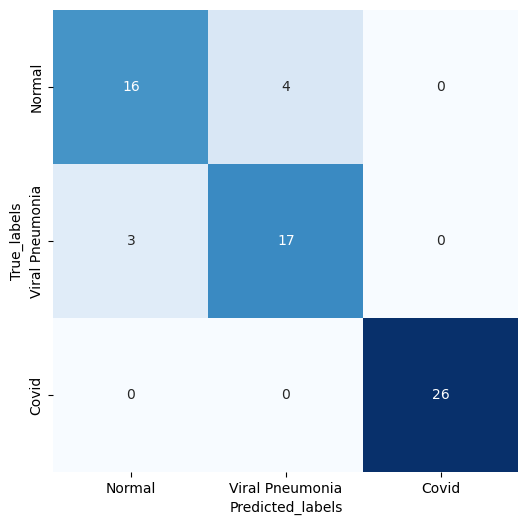

In [11]:
ytest_vgg16, ypred_vgg16, ypred_prob_vgg16 = evaluate_ensemble_model(model_vgg16, test_generator)

In [12]:
calculate_performance_metrics(ytest_vgg16, ypred_vgg16)

Accuracy: 89.39%
Precision: 89.44%
Recall: 89.39%
F1-Score: 89.39%


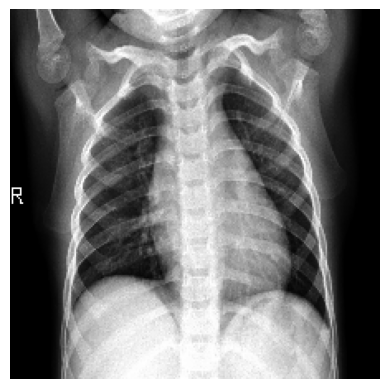

1/1 [==============================] - 0s 264ms/step
[[0.40333366 0.56372684 0.03293948]]
[1]
[0.56372684]
Predicted: Viral Pneumonia
Actual: Normal




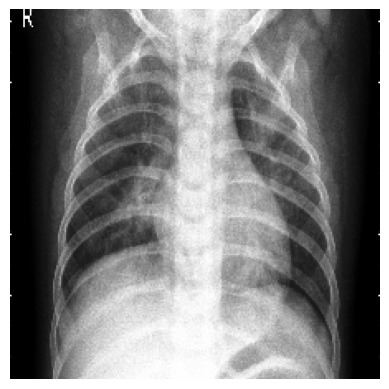

1/1 [==============================] - 0s 20ms/step
[[0.06063903 0.9140977  0.02526325]]
[1]
[0.9140977]
Predicted: Viral Pneumonia
Actual: Viral Pneumonia




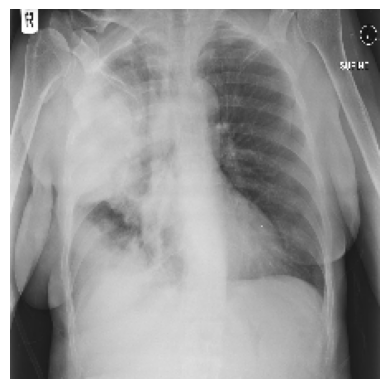

1/1 [==============================] - 0s 20ms/step
[[0.00495887 0.10428776 0.89075345]]
[2]
[0.89075345]
Predicted: Covid
Actual: Covid


In [13]:
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0109.jpeg',model_vgg16)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Viral Pneumonia/0105.jpeg',model_vgg16)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Covid/0113.jpg',model_vgg16)

***InceptionV3***

In [14]:
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_InceptionV3 = create_custom_model(base_model, input_shape, False, 3)

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [15]:
history_InceptionV3 = train_and_evaluate_model(model_InceptionV3, 'InceptionV3', epochs=50, monitor_acc='acc', monitor_val_loss='val_loss', patience=5, verbose=1)
history_to_csv(history_InceptionV3,'history_InceptionV3_new.csv')

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.4586 - acc: 0.4861
Epoch 1: acc improved from -inf to 0.48606, saving model to Model_new/InceptionV3_best.h5
4/4 [==============================] - 24s 5s/step - loss: 1.4586 - acc: 0.4861 - val_loss: 0.7744 - val_acc: 0.6364
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.0943 - acc: 0.5418
Epoch 2: acc improved from 0.48606 to 0.54183, saving model to Model_new/InceptionV3_best.h5
4/4 [==============================] - 15s 4s/step - loss: 1.0943 - acc: 0.5418 - val_loss: 0.6737 - val_acc: 0.6970
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.8161 - acc: 0.6574
Epoch 3: acc improved from 0.54183 to 0.65737, saving model to Model_new/InceptionV3_best.h5
4/4 [==============================] - 15s 4s/step - loss: 0.8161 - acc: 0.6574 - val_loss: 0.6921 - val_acc: 0.6515
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.7693 - acc: 0.7012
Epoch 4: acc improved fro

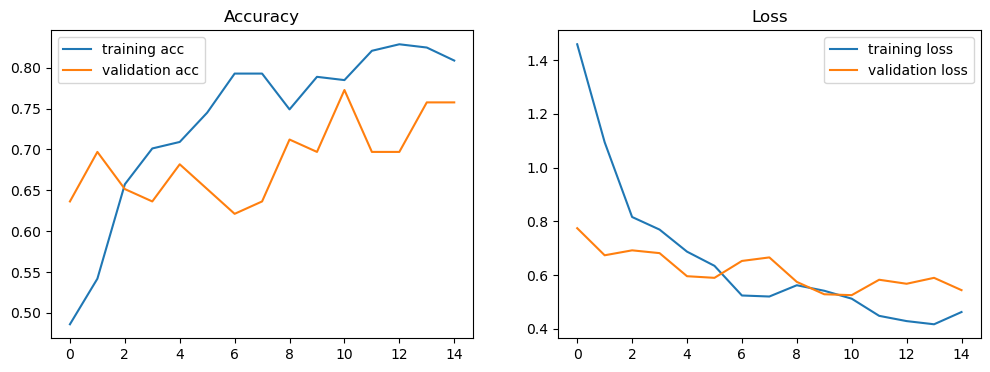

In [16]:
plot_learning_curve(history_InceptionV3)

3/3 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.30      0.44        20
         1.0       0.57      1.00      0.73        20
         2.0       1.00      0.92      0.96        26

    accuracy                           0.76        66
   macro avg       0.81      0.74      0.71        66
weighted avg       0.83      0.76      0.73        66



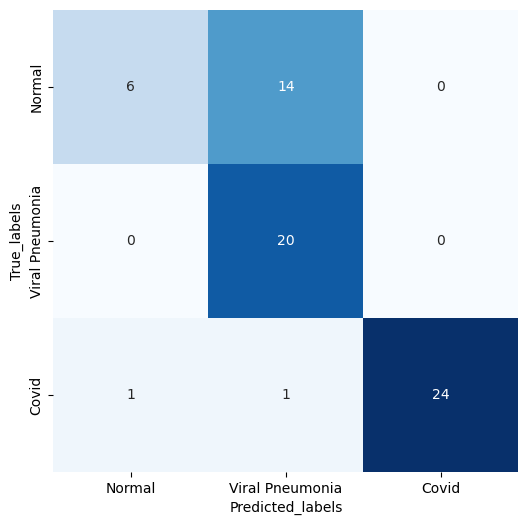

In [17]:
ytest_InceptionV3, ypred_InceptionV3, ypred_prob_InceptionV3 = evaluate_ensemble_model(model_InceptionV3, test_generator)

In [18]:
calculate_performance_metrics(ytest_InceptionV3, ypred_InceptionV3)

Accuracy: 75.76%
Precision: 82.68%
Recall: 75.76%
F1-Score: 73.32%


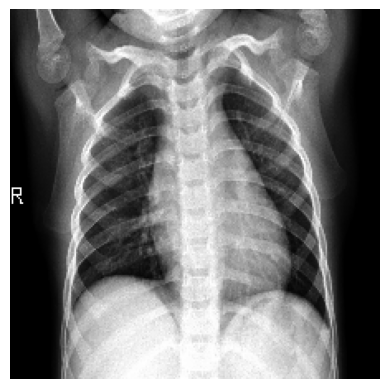

1/1 [==============================] - 0s 224ms/step
[[0.15000121 0.84494185 0.00505698]]
[1]
[0.84494185]
Predicted: Viral Pneumonia
Actual: Normal




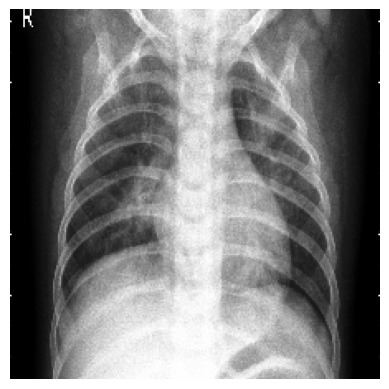

1/1 [==============================] - 0s 29ms/step
[[0.08607339 0.90782183 0.00610469]]
[1]
[0.90782183]
Predicted: Viral Pneumonia
Actual: Viral Pneumonia




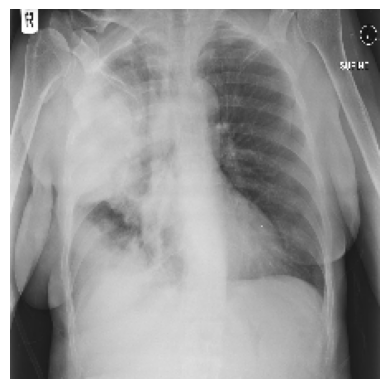

1/1 [==============================] - 0s 28ms/step
[[0.0225805  0.03104712 0.9463724 ]]
[2]
[0.9463724]
Predicted: Covid
Actual: Covid


In [19]:
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0109.jpeg',model_InceptionV3)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Viral Pneumonia/0105.jpeg',model_InceptionV3)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Covid/0113.jpg',model_InceptionV3)

***DenseNet201***

In [20]:
input_shape = (height, width, 3)
base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
model_DenseNet201 = create_custom_model(base_model, input_shape, False, 3)

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [21]:
history_DenseNet201 = train_and_evaluate_model(model_DenseNet201, 'DenseNet201', epochs=50, monitor_acc='acc', monitor_val_loss='val_loss', patience=5, verbose=1)
history_to_csv(history_DenseNet201,'history_DenseNet201_new.csv')

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.2074 - acc: 0.4661
Epoch 1: acc improved from -inf to 0.46614, saving model to Model_new/DenseNet201_best.h5
4/4 [==============================] - 35s 6s/step - loss: 1.2074 - acc: 0.4661 - val_loss: 0.9081 - val_acc: 0.4545
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 0.8433 - acc: 0.6255
Epoch 2: acc improved from 0.46614 to 0.62550, saving model to Model_new/DenseNet201_best.h5
4/4 [==============================] - 16s 4s/step - loss: 0.8433 - acc: 0.6255 - val_loss: 0.6667 - val_acc: 0.6970
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.7302 - acc: 0.6813
Epoch 3: acc improved from 0.62550 to 0.68127, saving model to Model_new/DenseNet201_best.h5
4/4 [==============================] - 16s 4s/step - loss: 0.7302 - acc: 0.6813 - val_loss: 0.5964 - val_acc: 0.6970
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.5985 - acc: 0.7490
Epoch 4: acc improved fro

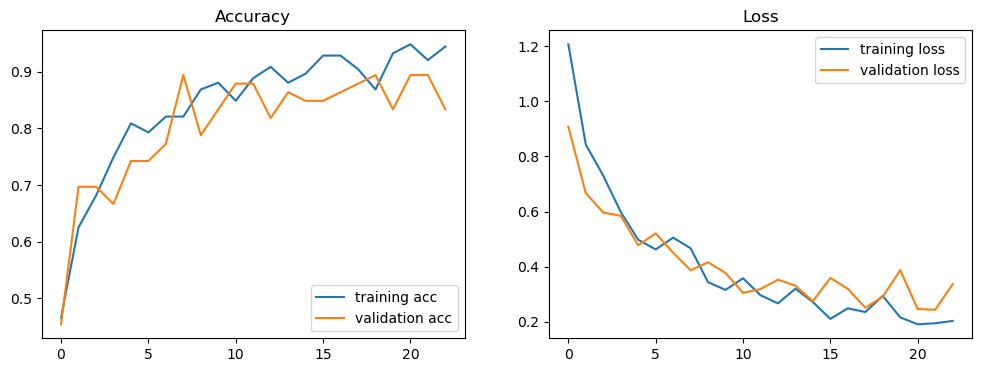

In [22]:
plot_learning_curve(history_DenseNet201)

3/3 [==============================] - 4s 54ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        20
         1.0       0.89      0.80      0.84        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.91        66
   macro avg       0.90      0.90      0.90        66
weighted avg       0.91      0.91      0.91        66



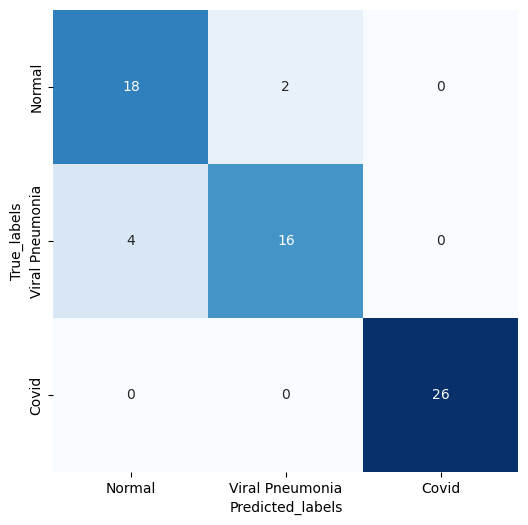

In [23]:
ytest_DenseNet201, ypred_DenseNet201, ypred_prob_DenseNet201 = evaluate_ensemble_model(model_DenseNet201, test_generator)

In [24]:
calculate_performance_metrics(ytest_DenseNet201, ypred_DenseNet201)

Accuracy: 90.91%
Precision: 91.12%
Recall: 90.91%
F1-Score: 90.89%


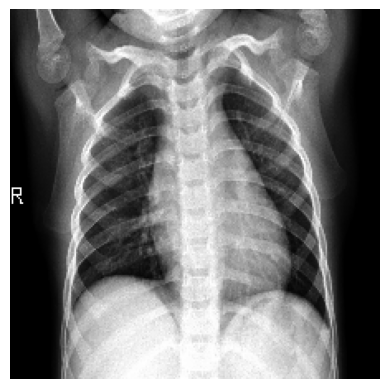

1/1 [==============================] - 1s 525ms/step
[[0.65275735 0.34159875 0.00564394]]
[0]
[0.65275735]
Predicted: Normal
Actual: Normal




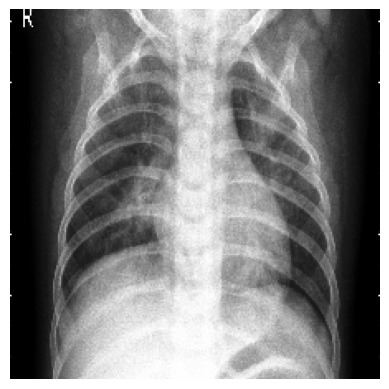

1/1 [==============================] - 0s 41ms/step
[[0.0319497  0.9623241  0.00572629]]
[1]
[0.9623241]
Predicted: Viral Pneumonia
Actual: Viral Pneumonia




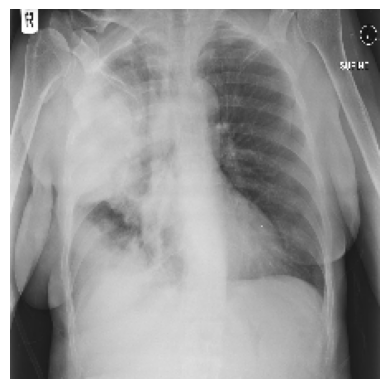

1/1 [==============================] - 0s 40ms/step
[[9.7130908e-04 1.9849674e-03 9.9704367e-01]]
[2]
[0.99704367]
Predicted: Covid
Actual: Covid


In [25]:
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0109.jpeg',model_DenseNet201)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Viral Pneumonia/0105.jpeg',model_DenseNet201)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Covid/0113.jpg',model_DenseNet201)

***ConvNeXtXLarge***

In [26]:
input_shape = (height, width, 3)
base_model = tf.keras.applications.ConvNeXtXLarge(weights='imagenet', include_top=False, input_shape=input_shape)
model_ConvNeXtXLarge = create_custom_model(base_model, input_shape, False, 3)

1393257616/1393257616 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_xlarge (Functional  (None, 7, 7, 2048)       348147968 
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                     

In [27]:
history_ConvNeXtXLarge = train_and_evaluate_model(model_ConvNeXtXLarge, 'ConvNeXtXLarge', epochs=50, monitor_acc='acc', monitor_val_loss='val_loss', patience=5, verbose=1)
history_to_csv(history_ConvNeXtXLarge,'history_ConvNeXtXLarge_new.csv')

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.5631 - acc: 0.3865
Epoch 1: acc improved from -inf to 0.38645, saving model to Model_new/ConvNeXtXLarge_best.h5
4/4 [==============================] - 57s 11s/step - loss: 1.5631 - acc: 0.3865 - val_loss: 0.8851 - val_acc: 0.4848
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.0865 - acc: 0.5378
Epoch 2: acc improved from 0.38645 to 0.53785, saving model to Model_new/ConvNeXtXLarge_best.h5
4/4 [==============================] - 25s 6s/step - loss: 1.0865 - acc: 0.5378 - val_loss: 0.6687 - val_acc: 0.8182
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.8543 - acc: 0.6096
Epoch 3: acc improved from 0.53785 to 0.60956, saving model to Model_new/ConvNeXtXLarge_best.h5
4/4 [==============================] - 24s 6s/step - loss: 0.8543 - acc: 0.6096 - val_loss: 0.5774 - val_acc: 0.7121
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.7284 - acc: 0.6733
Epoch 4: acc im

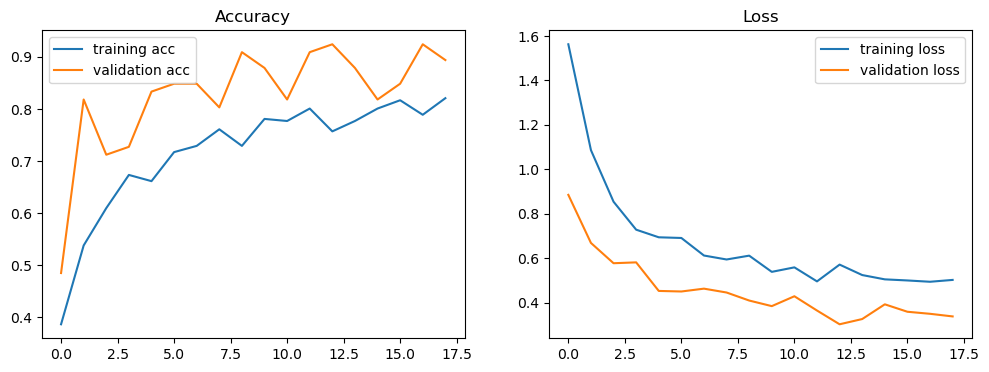

In [28]:
plot_learning_curve(history_ConvNeXtXLarge)

3/3 [==============================] - 8s 476ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77        20
         1.0       0.78      0.90      0.84        20
         2.0       1.00      0.92      0.96        26

    accuracy                           0.86        66
   macro avg       0.86      0.86      0.86        66
weighted avg       0.87      0.86      0.86        66



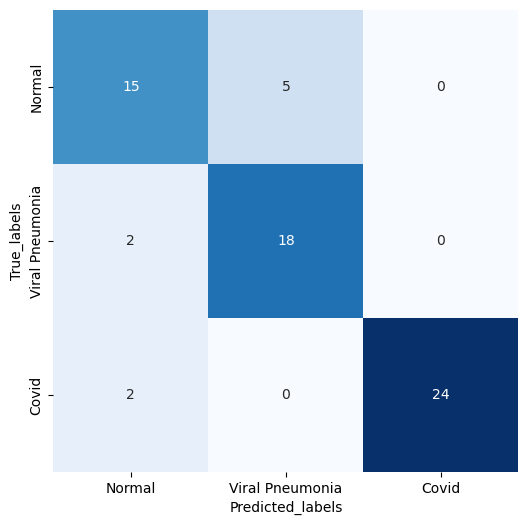

In [29]:
ytest_ConvNeXtXLarge, ypred_ConvNeXtXLarge, ypred_prob_ConvNeXtXLarge = evaluate_ensemble_model(model_ConvNeXtXLarge, test_generator)

In [30]:
calculate_performance_metrics(ytest_ConvNeXtXLarge, ypred_ConvNeXtXLarge)

Accuracy: 86.36%
Precision: 87.03%
Recall: 86.36%
F1-Score: 86.50%


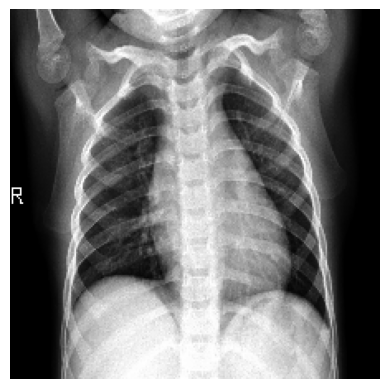

1/1 [==============================] - 3s 3s/step
[[0.664595   0.32901627 0.0063887 ]]
[0]
[0.664595]
Predicted: Normal
Actual: Normal




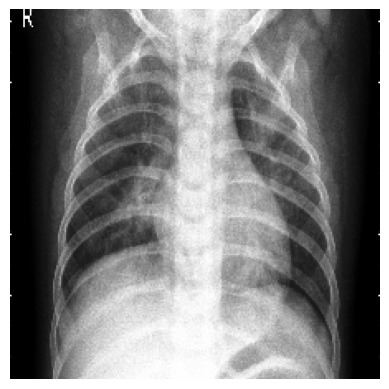

1/1 [==============================] - 0s 81ms/step
[[0.07510417 0.88647443 0.03842146]]
[1]
[0.88647443]
Predicted: Viral Pneumonia
Actual: Viral Pneumonia




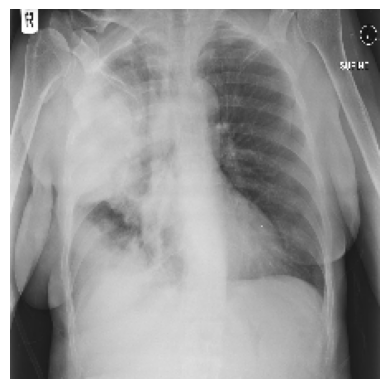

1/1 [==============================] - 0s 80ms/step
[[0.00140343 0.03840973 0.96018684]]
[2]
[0.96018684]
Predicted: Covid
Actual: Covid


In [31]:
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0109.jpeg',model_ConvNeXtXLarge)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Viral Pneumonia/0105.jpeg',model_ConvNeXtXLarge)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Covid/0113.jpg',model_ConvNeXtXLarge)

***EfficientNetV2S***

In [32]:
input_shape = (height, width, 3)
base_model = tf.keras.applications.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape)
model_EfficientNetV2S = create_custom_model(base_model, input_shape, False, 3)

82420632/82420632 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [33]:
history_EfficientNetV2S = train_and_evaluate_model(model_EfficientNetV2S, 'EfficientNetV2S', epochs=50, monitor_acc='acc', monitor_val_loss='val_loss', patience=5, verbose=1)
history_to_csv(history_EfficientNetV2S,'history_EfficientNetV2S_new.csv')

Epoch 1/50


2023-04-23 19:59:11.436150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - ETA: 0s - loss: 1.0837 - acc: 0.4263
Epoch 1: acc improved from -inf to 0.42629, saving model to Model_new/EfficientNetV2S_best.h5
4/4 [==============================] - 34s 6s/step - loss: 1.0837 - acc: 0.4263 - val_loss: 0.9367 - val_acc: 0.6364
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 0.9609 - acc: 0.5817
Epoch 2: acc improved from 0.42629 to 0.58167, saving model to Model_new/EfficientNetV2S_best.h5
4/4 [==============================] - 16s 4s/step - loss: 0.9609 - acc: 0.5817 - val_loss: 0.8433 - val_acc: 0.5909
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.9727 - acc: 0.5339
Epoch 3: acc did not improve from 0.58167
4/4 [==============================] - 15s 4s/step - loss: 0.9727 - acc: 0.5339 - val_loss: 0.7535 - val_acc: 0.6818
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.9192 - acc: 0.6016
Epoch 4: acc improved from 0.58167 to 0.60159, saving model to Model_new/Effici

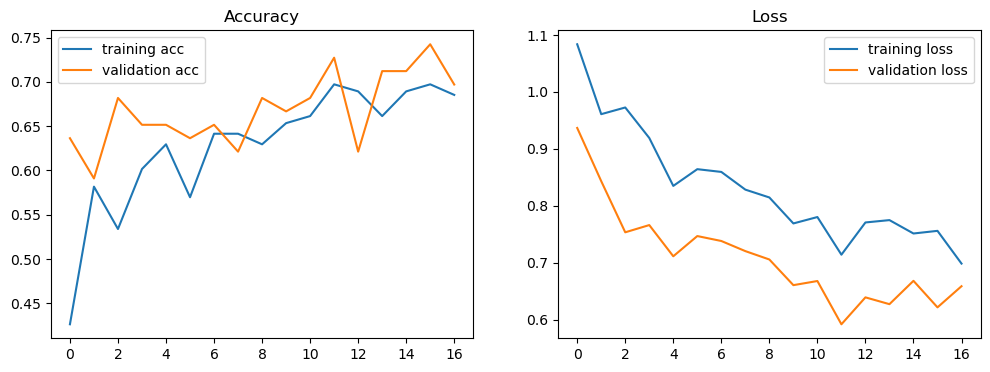

In [34]:
plot_learning_curve(history_EfficientNetV2S)

3/3 [==============================] - 4s 47ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.85      0.68        20
         1.0       0.71      0.25      0.37        20
         2.0       0.79      0.88      0.84        26

    accuracy                           0.68        66
   macro avg       0.69      0.66      0.63        66
weighted avg       0.70      0.68      0.65        66



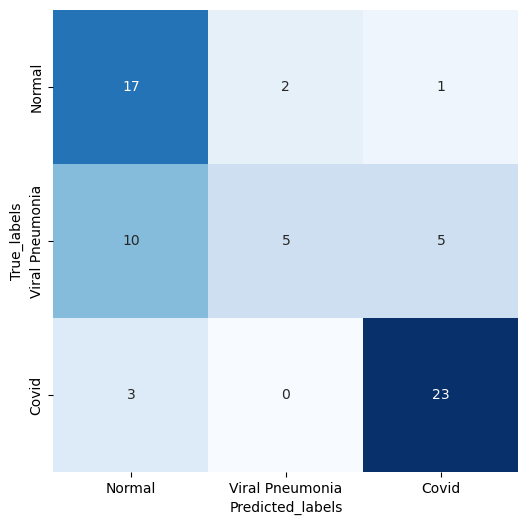

In [35]:
ytest_EfficientNetV2S, ypred_EfficientNetV2S, ypred_prob_EfficientNetV2S = evaluate_ensemble_model(model_EfficientNetV2S, test_generator)

In [36]:
calculate_performance_metrics(ytest_EfficientNetV2S, ypred_EfficientNetV2S)

Accuracy: 68.18%
Precision: 70.06%
Recall: 68.18%
F1-Score: 64.78%


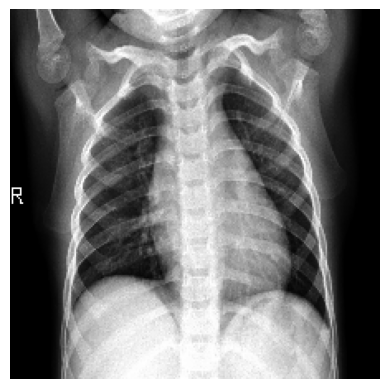

1/1 [==============================] - 0s 145ms/step
[[0.4826998  0.50339705 0.01390317]]
[1]
[0.50339705]
Predicted: Viral Pneumonia
Actual: Normal




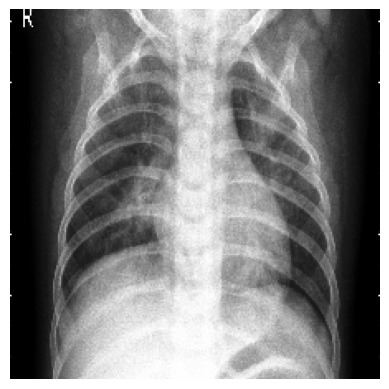

1/1 [==============================] - 0s 37ms/step
[[0.40729845 0.40258414 0.19011742]]
[0]
[0.40729845]
Predicted: Normal
Actual: Viral Pneumonia




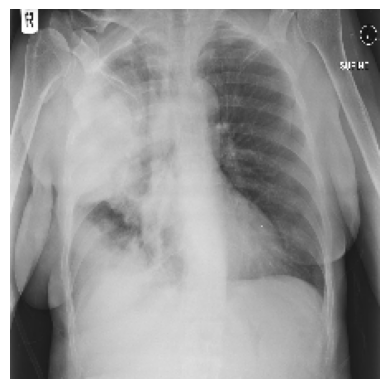

1/1 [==============================] - 0s 36ms/step
[[0.03878918 0.23930822 0.7219026 ]]
[2]
[0.7219026]
Predicted: Covid
Actual: Covid


In [37]:
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Normal/0109.jpeg',model_EfficientNetV2S)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Viral Pneumonia/0105.jpeg',model_EfficientNetV2S)
predict_image('/kaggle/input/covid19-dataset-x-ray/Covid19-dataset/test/Covid/0113.jpg',model_EfficientNetV2S)

***ROC Curve***

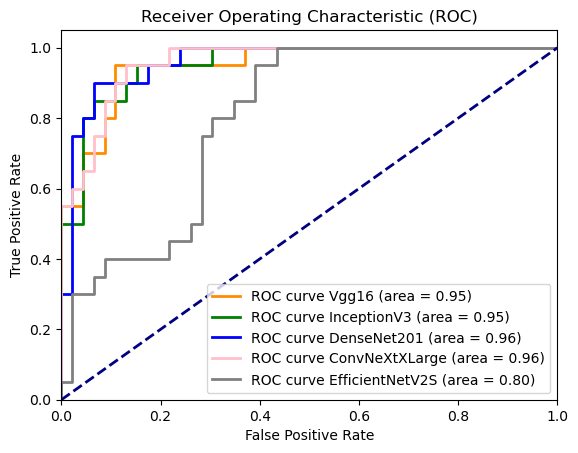

In [38]:
fpr_v, tpr_v, thresholds_v = roc_curve(ytest_vgg16, ypred_prob_vgg16[:,1], pos_label=1)
fpr_i, tpr_i, thresholds_i = roc_curve(ytest_InceptionV3, ypred_prob_InceptionV3[:,1], pos_label=1)
fpr_d, tpr_d, thresholds_d = roc_curve(ytest_DenseNet201, ypred_prob_DenseNet201[:,1], pos_label=1)
fpr_c, tpr_c, thresholds_c = roc_curve(ytest_ConvNeXtXLarge, ypred_prob_ConvNeXtXLarge[:,1], pos_label=1)
fpr_e, tpr_e, thresholds_e = roc_curve(ytest_EfficientNetV2S, ypred_prob_EfficientNetV2S[:,1], pos_label=1)

roc_auc_v = auc(fpr_v, tpr_v)
roc_auc_i = auc(fpr_i, tpr_i)
roc_auc_d = auc(fpr_d, tpr_d)
roc_auc_c = auc(fpr_c, tpr_c)
roc_auc_e = auc(fpr_e, tpr_e)

plt.plot(fpr_v, tpr_v, color='darkorange', lw=2, label='ROC curve Vgg16 (area = %0.2f)' % roc_auc_v)
plt.plot(fpr_i, tpr_i, color='green', lw=2, label='ROC curve InceptionV3 (area = %0.2f)' % roc_auc_i)
plt.plot(fpr_d, tpr_d, color='blue', lw=2, label='ROC curve DenseNet201 (area = %0.2f)' % roc_auc_d)
plt.plot(fpr_c, tpr_c, color='pink', lw=2, label='ROC curve ConvNeXtXLarge (area = %0.2f)' % roc_auc_c)
plt.plot(fpr_e, tpr_e, color='grey', lw=2, label='ROC curve EfficientNetV2S (area = %0.2f)' % roc_auc_e)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="best")
plt.show()